## import bibliotek

In [42]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import optuna
from optuna.trial import Trial

## Generowaie funkcji losowej

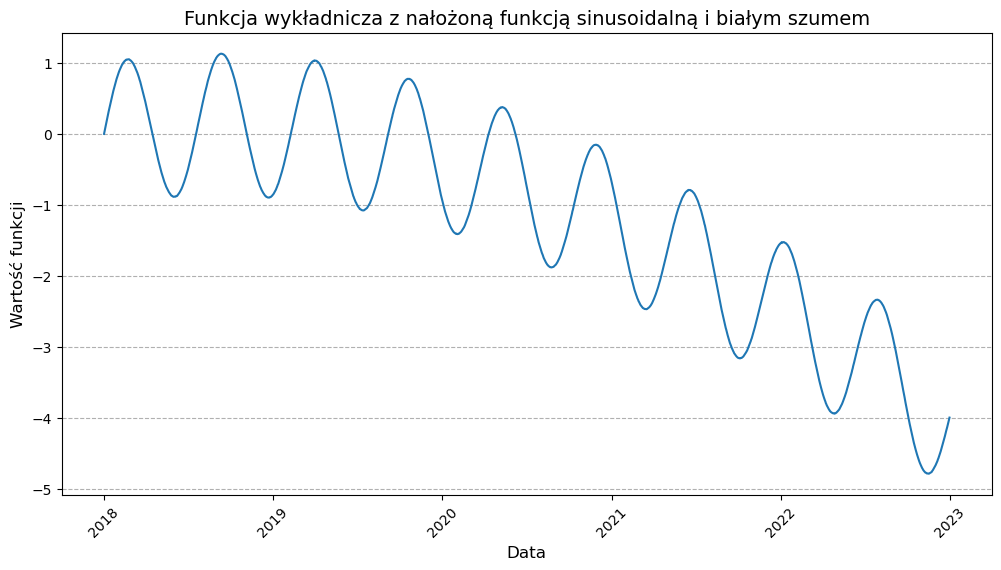

In [43]:
# Twój szereg czasowy (przykładowe dane)
daty = pd.date_range(start='2018-01-01', end='2022-12-31', freq='D')
df = pd.DataFrame({'data': daty})
df.set_index('data', inplace=True)

# Utwórz wektor czasu o długości takiej samej jak df
t = np.linspace(0, 1, len(df))  # Skalujemy czas do przedziału [0, 1]

# Wygeneruj funkcję wielomianową
poly_func = 2 * t**3 - 8 * t**2 + 2*t  # Przykładowy wielomian

# Wygeneruj funkcję sinusoidalną
sin_func = np.sin(18 * np.pi * t)

# Wygeneruj biały szum
noise = np.random.normal(0, 0.0015, len(df))

# Połącz funkcje i dodaj do DataFrame'u
df['combined_func'] = poly_func + sin_func + noise

# Tworzenie wykresu liniowego
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['combined_func'])

# Ustawienia wykresu
plt.xlabel('Data', fontsize=12)
plt.ylabel('Wartość funkcji', fontsize=12)
plt.title('Funkcja wykładnicza z nałożoną funkcją sinusoidalną i białym szumem', fontsize=14)
plt.xticks(rotation=45)  # Obrót etykiet osi X dla lepszej czytelności
plt.grid(axis='y', linestyle='--')  # Dodanie siatki na osi Y

# Wyświetlenie wykresu
plt.show()

### Generowanie podziału

In [44]:
# Ustawienia podziału
n_splits = 4  # Liczba foldów
fold_size = len(df) // n_splits  # Zaokrąglenie w dół, aby uniknąć przekroczenia zakresu

# Funkcja do generowania indeksów podziału
def custom_time_series_split(df, n_splits, fold_size):
    fold_start = 0  # Zaczynamy od początku
    for i in range(n_splits):
        fold_end = fold_start + fold_size - 1

        train_size = int(fold_size * 0.85)  # 85% na trening
        val_size = int(fold_size * 0.10)  # 10% na walidację
        test_size = fold_size - train_size - val_size  # 5% na test

        train_end = fold_start + train_size - 1
        val_start = train_end + 1
        val_end = val_start + val_size - 1
        test_start = val_end + 1
        test_end = fold_end

        # Indeksy dla zbiorów
        train_index = df.iloc[fold_start: train_end + 1].index
        test_index = df.iloc[test_start: test_end + 1].index

        # Sprawdzenia diagnostyczne
        assert train_end < val_start, f"Fold {i+1}: Zbiór treningowy nachodzi na walidacyjny!"
        assert val_end < test_start, f"Fold {i+1}: Zbiór walidacyjny nachodzi na testowy!"
        assert test_end <= len(df) - 1, f"Fold {i+1}: Zbiór testowy wykracza poza zakres danych!"

        yield train_index, test_index

        fold_start = test_end + 1  # Kolejny fold zaczyna się po końcu poprzedniego testu

# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(custom_time_series_split(df, n_splits, fold_size)):
    # Wyświetlanie indeksów w jednym wierszu
    val_start_date = train_index[-1] + pd.DateOffset(days=1)  # Zaczynamy dzień po treningu
    val_end_date = test_index[0] - pd.DateOffset(days=1)  # Kończymy dzień przed testem

    print(f"\nFold {fold+1}:")
    print(f"  Trening: od {train_index[0].date()} do {train_index[-1].date()}")
    print(f"  Walidacja: od {val_start_date.date()} do {val_end_date.date()}")
    print(f"  Test: od {test_index[0].date()} do {test_index[-1].date()}")



Fold 1:
  Trening: od 2018-01-01 do 2019-01-22
  Walidacja: od 2019-01-23 do 2019-03-08
  Test: od 2019-03-09 do 2019-04-01

Fold 2:
  Trening: od 2019-04-02 do 2020-04-22
  Walidacja: od 2020-04-23 do 2020-06-06
  Test: od 2020-06-07 do 2020-06-30

Fold 3:
  Trening: od 2020-07-01 do 2021-07-22
  Walidacja: od 2021-07-23 do 2021-09-05
  Test: od 2021-09-06 do 2021-09-29

Fold 4:
  Trening: od 2021-09-30 do 2022-10-21
  Walidacja: od 2022-10-22 do 2022-12-05
  Test: od 2022-12-06 do 2022-12-29


# Prosty model

Early stopping at epoch 36
Fold 1, Test Loss: 0.0001


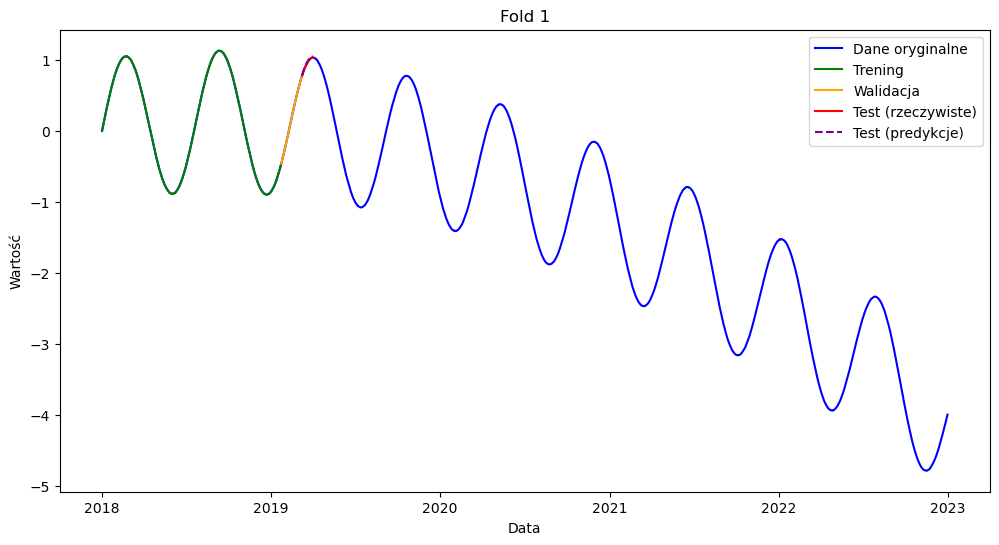

Early stopping at epoch 13
Fold 2, Test Loss: 0.0000


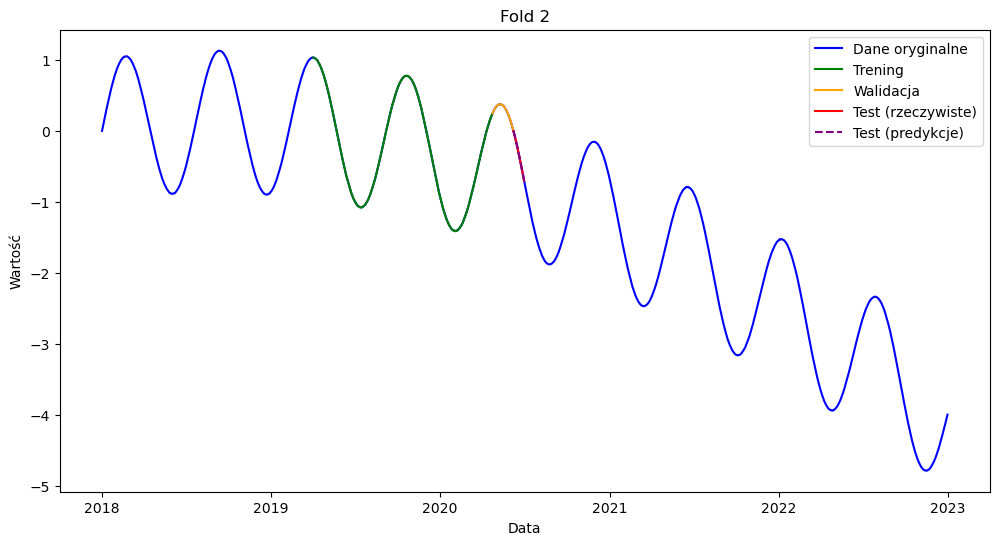

Early stopping at epoch 52
Fold 3, Test Loss: 0.0084


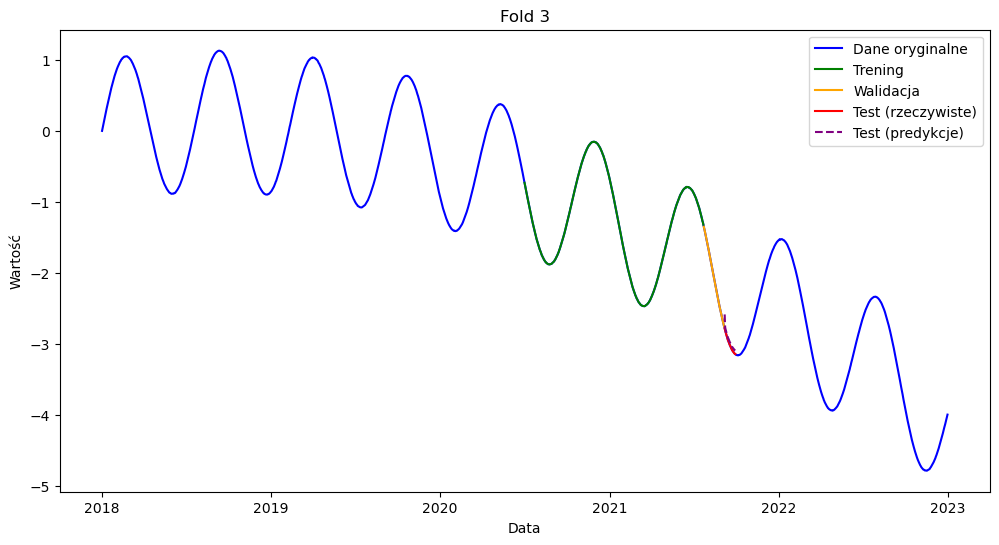

Fold 4, Test Loss: 0.0764


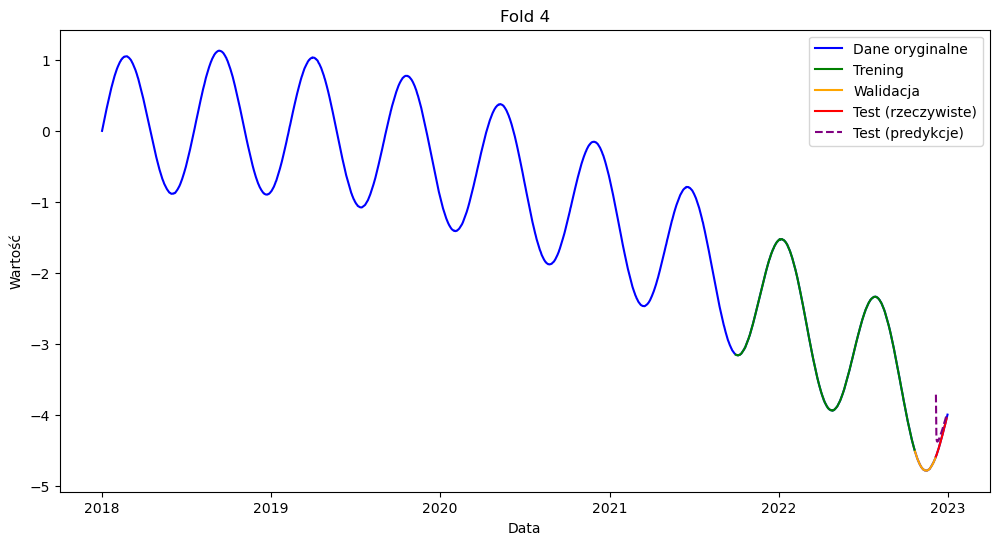

In [45]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, index, seq_length):
        self.data = torch.tensor(df.loc[index].values).float()
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return self.data[idx : idx + self.seq_length]  # Zwróć sekwencję


# Definicja modelu LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)  # Dodajemy Dropout po warstwie LSTM
        out = self.fc(out)
        return out

def create_data_loaders(df, train_index, val_index, test_index, seq_length, batch_size=32):
    train_dataset = TimeSeriesDataset(df, train_index, seq_length)
    val_dataset = TimeSeriesDataset(df, val_index, seq_length)
    test_dataset = TimeSeriesDataset(df, test_index, seq_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0

    for batch in data_loader:
        optimizer.zero_grad()
        outputs = model(batch)

        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(data_loader)

def evaluate(model, data_loader, criterion):
    model.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for batch in data_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch)
            eval_loss += loss.item()

    return eval_loss / len(data_loader)

# Parametry modelu
seq_length = 10  # Długość sekwencji wejściowej
input_dim = 1
hidden_dim = 96
num_layers = 2
output_dim = 1  # Przewidywana wartość
num_epochs = 80
dropout_prob = 0.2  #

# Tworzenie modelu
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout_prob)

# Funkcja straty i optymalizator
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00225, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=24) #scheduler szybkości uczenia


# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(custom_time_series_split(df, n_splits, fold_size)):
    # Wyświetlanie indeksów w jednym wierszu
    val_start_date = train_index[-1] + pd.DateOffset(days=1)  # Zaczynamy dzień po treningu
    val_end_date = test_index[0] - pd.DateOffset(days=1)  # Kończymy dzień przed testem

    val_index = df[(df.index >= val_start_date) & (df.index <= val_end_date)].index

    train_loader, val_loader, test_loader = create_data_loaders(df, train_index, val_index, test_index,seq_length=seq_length)

    best_val_loss = float('inf')  # Dla wczesnego zatrzymania
    patience_counter = 0
    # Trening
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)

        # Walidacja
        val_loss = evaluate(model, val_loader, criterion)

        #print(f"Fold {fold+1}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Wczesne zatrzymanie
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 12:  # Przerwij po 15 epokach bez poprawy
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step(val_loss)  # Dostosowanie szybkości uczenia

    # Test (ewaluacja na zbiorze testowym)
    test_loss = evaluate(model, test_loader, criterion)

    print(f"Fold {fold+1}, Test Loss: {test_loss:.4f}")

    # Wizualizacja
    plt.figure(figsize=(12, 6))

    # Oryginalne dane
    plt.plot(df.index, df.values, label="Dane oryginalne", color="blue")

    # Dane treningowe
    plt.plot(train_index, df.loc[train_index], label="Trening", color="green")

    # Dane walidacyjne
    plt.plot(val_index, df.loc[val_index], label="Walidacja", color="orange")

    # Dane testowe i predykcje
    plt.plot(test_index, df.loc[test_index], label="Test (rzeczywiste)", color="red")
    with torch.no_grad():
        test_pred = model(torch.tensor(df.loc[test_index].values).float().unsqueeze(0))
    plt.plot(test_index, test_pred.numpy().flatten(), label="Test (predykcje)", color="purple", linestyle="--")

    plt.xlabel("Data")
    plt.ylabel("Wartość")
    plt.title(f"Fold {fold + 1}")
    plt.legend()
    plt.show()

# Optuna

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, index, seq_length):
        self.data = torch.tensor(df.loc[index].values).float()
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return self.data[idx : idx + self.seq_length]  # Zwróć sekwencję


# Definicja modelu LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)  # Dodajemy Dropout po warstwie LSTM
        out = self.fc(out)
        return out

def create_data_loaders(df, train_index, val_index, test_index, seq_length, batch_size=32):
    train_dataset = TimeSeriesDataset(df, train_index, seq_length)
    val_dataset = TimeSeriesDataset(df, val_index, seq_length)
    test_dataset = TimeSeriesDataset(df, test_index, seq_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0

    for batch in data_loader:
        optimizer.zero_grad()
        outputs = model(batch)

        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(data_loader)

def evaluate(model, data_loader, criterion):
    model.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for batch in data_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch)
            eval_loss += loss.item()

    return eval_loss / len(data_loader)

# Parametry modelu
#seq_length = 10  # Długość sekwencji wejściowej
input_dim = 1
output_dim = 1  # Przewidywana wartość
num_epochs = 160

def objective(trial: Trial, df, n_splits, fold_size):
    # Hiperparametry do optymalizacji
    hidden_dim = trial.suggest_int("hidden_dim", 4, 186)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_float("lr", 1e-6, 1e-2)
    dropout_prob = trial.suggest_float("dropout_prob", 0.0, 0.4)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3)
    seq_length  =  trial.suggest_int("seq_length", 4, 16)

    # Tworzenie modelu i optymalizatora
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout_prob)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Funkcja straty i scheduler
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=22)

    total_val_loss = 0.0  # strata walidacyjna
    total_test_loss = 0.0  # strata testowa
    
    # Iteracja po foldach
    for fold, (train_index, test_index) in enumerate(custom_time_series_split(df, n_splits, fold_size)):
        
        # Obliczanie indeksów walidacyjnych
        val_start_date = train_index[-1] + pd.DateOffset(days=1)
        val_end_date = test_index[0] - pd.DateOffset(days=1)
        val_index = df[(df.index >= val_start_date) & (df.index <= val_end_date)].index

        # Tworzenie DataLoaderów
        train_loader, val_loader, test_loader = create_data_loaders(
            df, train_index, val_index, test_index, seq_length
        )

        best_val_loss = float("inf")
        patience_counter = 0

        # Trening
        for epoch in range(num_epochs):
            train_loss = train_epoch(model, train_loader, criterion, optimizer)
            val_loss = evaluate(model, val_loader, criterion)
            test_loss = evaluate(model, test_loader, criterion)

            # Raportowanie wyniku do Optuny
            trial.report(val_loss + test_loss, epoch)

            # Wczesne zatrzymanie przez Optunę
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            # Wczesne zatrzymywanie i zapamiętywanie najlepszego modelu
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 14:
                    break
            total_val_loss += best_val_loss
            total_test_loss += test_loss
            scheduler.step(val_loss)

    avg_val_loss = total_val_loss / n_splits
    avg_test_loss = total_test_loss / n_splits

    return avg_val_loss + avg_test_loss
# Uruchomienie optymalizacji
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(n_startup_trials=48), pruner=None) 
study.optimize(lambda trial: objective(trial, df, n_splits, fold_size), n_trials=60)  

print("Najlepsze hiperparametry:", study.best_params)
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

[I 2024-06-05 23:07:18,506] A new study created in memory with name: no-name-af8b60da-c3c8-4c72-9a02-1185c7cf784b
[I 2024-06-05 23:07:24,999] Trial 0 finished with value: 296.8787550224033 and parameters: {'hidden_dim': 7, 'num_layers': 1, 'lr': 0.0006267638348565378, 'dropout_prob': 0.2000880152281618, 'weight_decay': 0.0006585184902947791, 'seq_length': 6}. Best is trial 0 with value: 296.8787550224033.
[I 2024-06-05 23:07:27,448] Trial 1 finished with value: 13.240171019684794 and parameters: {'hidden_dim': 19, 'num_layers': 1, 'lr': 0.007602168915012379, 'dropout_prob': 0.2766377120716065, 'weight_decay': 5.879384368232306e-05, 'seq_length': 4}. Best is trial 1 with value: 13.240171019684794.
[I 2024-06-05 23:07:35,941] Trial 2 finished with value: 42.23554905545325 and parameters: {'hidden_dim': 42, 'num_layers': 2, 'lr': 0.006071496171052684, 'dropout_prob': 0.3820937122509822, 'weight_decay': 0.0007270059931181662, 'seq_length': 15}. Best is trial 1 with value: 13.24017101968479

#### Najlepsze hiperparametry: {'hidden_dim': 74, 'num_layers': 1, 'lr': 0.009700919683472314, 'dropout_prob': 0.007782489746004107, 'weight_decay': 0.0009384997118710685, 'seq_length': 14}